# **Megaline: Subscriber Data Auditing & Preprocessing**

## **Project Overview**

This project analyzes **subscriber behavior**, **consumption patterns**, and **revenue streams** for Megaline to identify the factors that drive **plan profitability**. Our goal is to provide a data-driven foundation for the company's **commercial strategy** by transforming raw usage logs into **actionable insights**.

**Note:** For a detailed breakdown of the business context, data dictionary, and full project requirements, please refer to the [README.md](https://github.com/fiorellatrigo/estudio_clientes_telefonia/blob/main/README.md).

## **Executive Summary: Executive Summary: Revenue and Usage Analysis of Prepaid Plans**

* This analysis evaluates customer behavior and profitability across Megaline’s two prepaid plans, Surf and Ultimate, using data on calls, messages, internet usage, and monthly revenue.

* Although average usage levels are similar across plans, user behavior differs substantially. Surf users frequently exceed plan limits, especially in mobile data, generating significant variable revenue through overage charges. In contrast, Ultimate users consistently remain well below their generous allowances, resulting in stable but lower effective profitability.

* Statistical hypothesis testing confirms that Surf generates significantly higher average revenue than Ultimate (p ≪ 0.05), while no significant revenue differences are observed by geographic region (NY–NJ vs. other areas).

* **Key business insight**:
Despite its lower base price, **Surf is the most profitable plan**, driven by overconsumption—particularly of internet data—whereas **Ultimate prioritizes user stability** over revenue maximization.

## **1. Data Preparation and Standardization**

In [2]:
# Load libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

In [3]:
# Load Datasets
df_users = pd.read_csv("../data/megaline_users.csv")
df_calls= pd.read_csv("../data/megaline_calls.csv")
df_messages= pd.read_csv("../data/megaline_messages.csv")
df_internet= pd.read_csv("../data/megaline_internet.csv")
df_plans= pd.read_csv("../data/megaline_plans.csv")

In [4]:
# List of our dataframes and their names for auditing
dataframes = {
    'Users': df_users,
    'Calls': df_calls,
    'Messages': df_messages,
    'Internet': df_internet,
    'Plans': df_plans
}

# Quick audit: Checking for missing values and data types across all tables
for name, df in dataframes.items():
    print(f"--- Table: {name} ---")
    print(df.info())
    print(f"Duplicates: {df.duplicated().sum()}")
    print("\n")

--- Table: Users ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
Duplicates: 0


--- Table: Calls ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(

### **1.1. Data Cleaning & Transformation Decisions**

After auditing the datasets, the following steps are taken to ensure data consistency and **prepare the tables for analysis**:

* **Plan Table Reordering:** Columns in `df_plans` are reorganized for better readability, placing the plan name and monthly cost first.
* **Missing Value Imputation:** In the `df_users` table, null values in the `churn_date` column are filled with '2019-01-01'. This placeholder represents users who were still active at the time the data was collected.
* **Type Conversion:** Date columns in are converted to `datetime` objects to allow for time-based calculations and monthly aggregations.

In [5]:
# Reorder columns in df_plans for better readability
new_order = ['plan_name', 'usd_monthly_pay', 'minutes_included',
             'messages_included', 'mb_per_month_included',
             'usd_per_minute', 'usd_per_message', 'usd_per_gb']

df_plans = df_plans[new_order]

In [6]:
# Handle missing values in Users table
# '2019-01-01' is used as a placeholder for active subscribers
df_users['churn_date'] = df_users['churn_date'].fillna('2019-01-01')

In [7]:
# Data type correction: Converting strings to datetime
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')

### **1.2. Feature Engineering & Data Enrichment**

To align the raw data with Megaline's business logic and prepare for monthly analysis, the following enhancements were implemented:

* **Plan Specification:** Converted `mb_per_month_included` to GB for direct comparison with data usage limits.
* **Call Duration Normalization:** Rounded up call durations to the nearest minute, as per the company's billing policy.
* **Temporal Segmentation:** Extracted the month from all transaction dates (calls, messages, and internet sessions) to enable monthly behavioral tracking.
* **Data Integration:** Merged user plan information into the consumption tables to allow for comparative analysis between "Smart" and "Ultra" subscribers.

In [8]:
# Enriching df_plans: Convert MB to GB
df_plans.insert(5, 'gb_per_month_included', (df_plans['mb_per_month_included'] / 1024).astype(int))

In [9]:
# Enriching df_calls: Rounding duration and adding temporal/plan data
df_calls['duration_min_int'] = np.ceil(df_calls['duration']).astype(int)
df_calls.insert(3, 'call_month', df_calls['call_date'].dt.month)
df_calls = df_calls.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

In [10]:
# Enriching df_messages: Adding month and plan info
df_messages.insert(3, 'message_month', df_messages['message_date'].dt.month)
df_messages = df_messages.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

In [11]:
# Enriching df_internet: Adding month and plan info
df_internet.insert(3, 'session_month', df_internet['session_date'].dt.month)
df_internet = df_internet.merge(df_users[['user_id', 'plan']], on='user_id', how='left')

### **1.3. Monthly Usage Aggregation**
To determine the **total consumption per subscriber**, the individual logs for **calls, messages, and internet** sessions are aggregated on a monthly basis. This transformation is essential for comparing actual **usage** against **plan limits** and calculating **potential overage fees**.

### **Key adjustments made during this process:**

* **Internet Normalization:** Total monthly megabytes are converted to gigabytes and rounded up, following Megaline’s specific data billing policy.

* **Uniform Indexing:** All tables are synchronized using a standard month column for seamless merging in the next stage.

In [12]:
# Aggregating Call Data (Count and Total Duration)
calls_per_user_month = df_calls.groupby(['user_id', 'call_month']).agg(
    calls_count=('duration_min_int', 'count'),
    minutes_total=('duration_min_int', 'sum')
).reset_index().rename(columns={'call_month': 'month'})

In [13]:
# Aggregating Message Data
messages_per_user_month = df_messages.groupby(['user_id', 'message_month']).size().reset_index(
    name='message_count'
).rename(columns={'message_month': 'month'})

In [14]:
# Aggregating Internet Data (Calculating total GB per month)
gb_per_user_month = df_internet.groupby(['user_id', 'session_month'])['mb_used'].sum().reset_index(
    name='gb_total'
)

# Converting MB to GB and rounding up
gb_per_user_month['gb_total'] = np.ceil(gb_per_user_month['gb_total'] / 1024).astype(int)
gb_per_user_month = gb_per_user_month.rename(columns={'session_month': 'month'})

In [15]:
# Displaying first results for verification
print("Monthly consumption summaries created.")
display(gb_per_user_month.head())

Monthly consumption summaries created.


,user_id,month,gb_total
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19


### **1.4. Data Consolidation: Creating the Master Dataset**
To perform a comprehensive analysis, we merge **all monthly consumption summaries** (calls, messages, and internet) into a single unified DataFrame. This consolidated view allows us to calculate the **total revenue per user** and compare their behavior against the specific limits of their assigned plan.

We use an **outer join** to ensure that subscribers who only used one type of service (e.g., only data but no SMS) are still **included** in the final report.

In [16]:
# Merging monthly consumption tables
# We start with calls and messages
df_merged = calls_per_user_month.merge(messages_per_user_month, on=['user_id', 'month'], how='outer')

# Merging with internet usage
df_merged = df_merged.merge(gb_per_user_month, on=['user_id', 'month'], how='outer')

# Merging with user information and plan details
df_merged = df_merged.merge(df_users[['user_id', 'plan', 'city']], on='user_id', how='left')
df_final = df_merged.merge(df_plans, left_on='plan', right_on='plan_name', how='left')

In [17]:
# Handling NaN values
# If a user didn't use a service in a month, the value is NaN. We fill it with 0.
fill_cols = ['calls_count', 'minutes_total', 'message_count', 'gb_total']
df_final[fill_cols] = df_final[fill_cols].fillna(0)

# Data Type Optimization: Converting floats back to integers for cleaner presentation
df_final[fill_cols] = df_final[fill_cols].astype(int)

# Cleaning up redundant columns
df_final = df_final.drop(columns=['plan_name', 'mb_per_month_included'])

print("Master Dataset created successfully.")
display(df_final.head())

Master Dataset created successfully.


,user_id,month,calls_count,minutes_total,message_count,gb_total,plan,city,usd_monthly_pay,minutes_included,messages_included,gb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb
0,1000,12,16,124,11,2,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70,3000,1000,30,0.01,0.01,7
1,1001,8,27,182,30,7,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
2,1001,9,49,315,44,14,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
3,1001,10,65,393,53,22,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10
4,1001,11,64,426,36,19,surf,"Seattle-Tacoma-Bellevue, WA MSA",20,500,50,15,0.03,0.03,10


### **1.4.1. Regional Segmentation**
To prepare for the statistical hypothesis testing, we categorize users based on their location. Specifically, we differentiate subscribers in the NY-NJ metropolitan area from those in the rest of the country. This allows us to analyze if geographical location influences revenue patterns.

In [18]:
# Defining the regional classification function
def classify_region(city):
    """
    Categorizes the city into 'NY-NJ' area or 'Other' regions.
    """
    if 'New York-Newark-Jersey City' in city:
        return 'NY-NJ'
    return 'Other'

# 2. Applying the classification to our master dataset
df_final['region'] = df_final['city'].apply(classify_region)

# 3. Verifying the distribution
print("Regional distribution of monthly records:")
display(df_final['region'].value_counts())

Regional distribution of monthly records:


region
Other    1916
NY-NJ     377
Name: count, dtype: int64

### **1.5. Monthly Revenue Calculation**
The final step in our data preparation is to calculate the **total monthly revenue** generated by **each user**. This involves a **custom function** that:

* Calculates the **excess usage** for calls, messages, and data.

* Multiplies these surpluses by the specific rates of the user's plan.

* Adds the **fixed monthly base fee**.

In [19]:
def calculate_monthly_revenue(row):
    """
    Calculates the total monthly revenue per user based on consumption and plan limits.
    """
    # 1. Base monthly fee
    revenue = row['usd_monthly_pay']
    
    # 2. Calculate call overages (if any)
    if row['minutes_total'] > row['minutes_included']:
        extra_minutes = row['minutes_total'] - row['minutes_included']
        revenue += extra_minutes * row['usd_per_minute']
        
    # 3. Calculate message overages (if any)
    if row['message_count'] > row['messages_included']:
        extra_messages = row['message_count'] - row['messages_included']
        revenue += extra_messages * row['usd_per_message']
        
    # 4. Calculate internet overages (if any)
    if row['gb_total'] > row['gb_per_month_included']:
        extra_gb = row['gb_total'] - row['gb_per_month_included']
        revenue += extra_gb * row['usd_per_gb']
        
    return revenue

# Applying the function to the entire dataset
df_final['monthly_revenue'] = df_final.apply(calculate_monthly_revenue, axis=1)

# Display a sample of users with their calculated revenue
print("Monthly revenue calculation completed.")
display(df_final[['user_id', 'month', 'plan', 'monthly_revenue']].head())

Monthly revenue calculation completed.


,user_id,month,plan,monthly_revenue
0,1000,12,ultimate,70.00
1,1001,8,surf,20.00
2,1001,9,surf,20.00
3,1001,10,surf,90.09
4,1001,11,surf,60.00


## **2. Exploratory Data Analysis (EDA)**

### **User Behavior Analysis: Consumption vs. Plan Limits**
In this section, we conduct a deep dive into **how subscribers utilize their plans**. By comparing average monthly usage, distributions, and the percentage of users who exceed their limits, we aim to identify which **services** (Calls, SMS, or Data) are the main drivers of **overage revenue**.

**Key metrics include:**

* **Plan Overages:** Using reference lines to visualize how many users surpass their "Smart" or "Ultra" allowances.

* **Distribution Skewness:** Identifying whether consumption is concentrated or spread out.

* **Monthly Stability:** Checking if consumption remains consistent throughout the year.

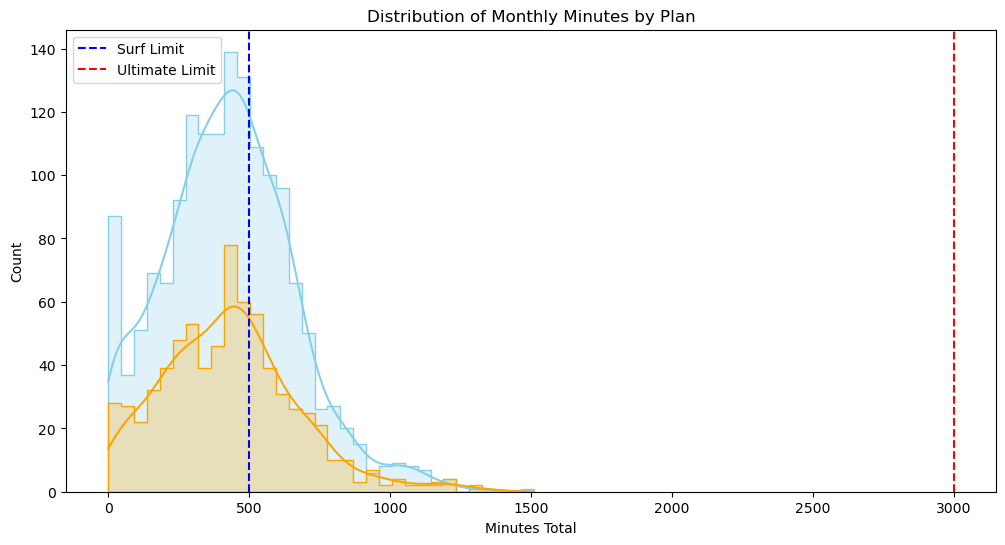

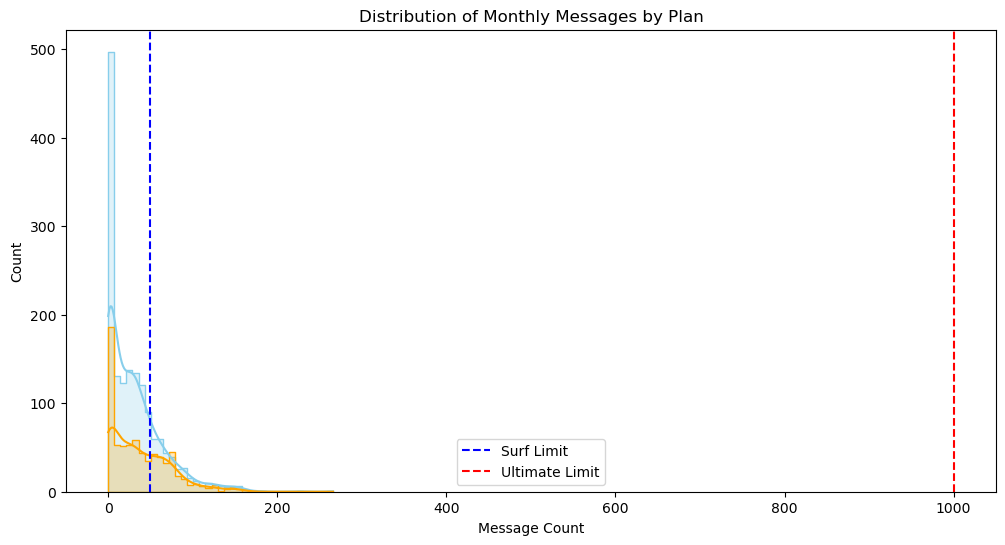

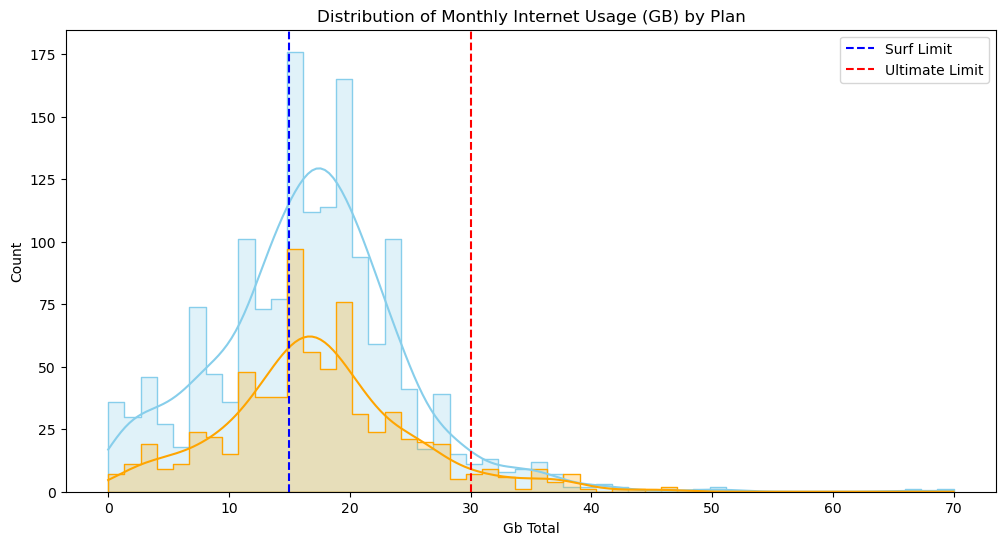

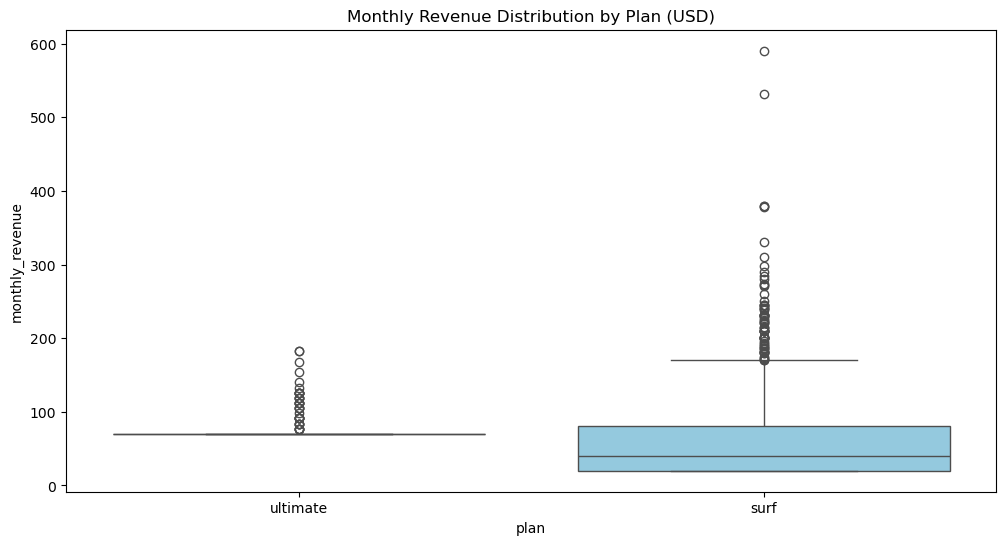

In [20]:
# Defining color palette and plan limits for consistency
colors = {'surf': 'skyblue', 'ultimate': 'orange'}
limits = {
    'minutes': {'surf': 500, 'ultimate': 3000},
    'messages': {'surf': 50, 'ultimate': 1000},
    'gb': {'surf': 15, 'ultimate': 30}
}

# Helper function to plot distribution with limit lines
def plot_consumption_analysis(column, title, limit_key):
    plt.figure(figsize=(12, 6))
    
    # Histogram
    sns.histplot(data=df_final, x=column, hue='plan', element="step", palette=colors, kde=True)
    
    # Add vertical lines for plan limits
    plt.axvline(limits[limit_key]['surf'], color='blue', linestyle='--', label='Surf Limit')
    plt.axvline(limits[limit_key]['ultimate'], color='red', linestyle='--', label='Ultimate Limit')
    
    plt.title(title)
    plt.xlabel(column.replace('_', ' ').title())
    plt.legend()
    plt.show()

# --- 1. CALLS ANALYSIS ---
plot_consumption_analysis('minutes_total', 'Distribution of Monthly Minutes by Plan', 'minutes')

# --- 2. MESSAGES ANALYSIS ---
plot_consumption_analysis('message_count', 'Distribution of Monthly Messages by Plan', 'messages')

# --- 3. INTERNET ANALYSIS ---
plot_consumption_analysis('gb_total', 'Distribution of Monthly Internet Usage (GB) by Plan', 'gb')

# --- 4. REVENUE ANALYSIS ---
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_final, 
    x='plan', 
    y='monthly_revenue', 
    hue='plan', 
    palette=colors,
    #showfliers=False
)
plt.title('Monthly Revenue Distribution by Plan (USD)')
plt.show()

## **Observations**
### **Graphic 1: Monthly Minutes Usage by Plan**

* Call usage is very similar across plans. Both Surf and Ultimate users show almost **identical distributions**, with monthly **averages around 430 minutes**, indicating that **call behavior is not influenced by the plan type**.

* The Surf plan exhibits a **slightly wider spread**, suggesting more **heterogeneous usage** patterns.

* **Surf** users partially exceed their included limit. While the average Surf consumption (~429 minutes) is below the 500-minute allowance, about **36% of users exceed the limit**, generating **additional revenue** from call overages.

* **Ultimate users never reach their call limit**. With 3000 included minutes, no Ultimate customer exceeds the allowance, confirming that the limit is largely above typical usage needs.


### **Graphic 2: Monthly Messages Usage by Plan**

* Message usage is generally low for both plans.

* 21.61% of Surf users exceed their SMS cap (50), generating overage revenue, while no Ultimate users approach their much higher limit (1000).

* Strategic implication: Surf users often underestimate their SMS needs and are good upgrade candidates, whereas Ultimate users significantly underutilize their plan, suggesting potential overpricing.

### **Graphic 3: Monthly Internet Usage (GB) by Plan**

* Average monthly internet usage is very similar across plans, with Surf at 16.7 GB and Ultimate at 17.3 GB, showing comparable medians and dispersion.

* The key difference lies in the extremes of the distribution: Surf shows a pronounced right tail with heavy users reaching up to 70 GB, while Ultimate’s usage is more contained, with no extreme outliers beyond 50 GB.

* This distributional pattern highlights distinct user profiles: Surf concentrates high-consumption users who frequently exceed plan limits (driving extra revenue), whereas Ultimate users display stable, predictable usage and largely underutilize their allowance.

### **Graphic 4: Monthly Revenue Distribution by Plan**

* Surf shows significantly higher average monthly revenue than Ultimate, nearly doubling it, but with much greater dispersion, as reflected by a wider interquartile range and numerous high-end outliers.

* The Surf revenue distribution is highly skewed, with values ranging from very low payments to extreme high-revenue users, indicating strong reliance on overage charges, especially from heavy data consumption.

* Ultimate displays a more compact and stable distribution, with revenues clustered around the base price and fewer extremes, suggesting predictable income but lower marginal profitability.

## **3. Statistical Hypothesis Testing**

### **1st Hypothesis**

* **Null hypothesis (H₀)**:
*The average revenue generated by users of the Ultimate and Surf calling plans is equal.*

* **Alternative hypothesis (H₁)**:
*The average revenue generated by users of the Ultimate and Surf calling plans differs.*

* **Statistical test**:
A two-tailed independent samples t-test is applied to assess whether the observed difference in mean revenues between the two plans is statistically significant or could be attributed to random variation.

* **Significance level (α)**:
0.05

In [ ]:
# Before running the hypothesis test, we assess sample adequacy and test for
# equality of variances (Levene’s test) to validate the assumptions of the t-test.

surf_earnings = df_final[df_final['plan'] == 'surf']['monthly_revenue']
ultimate_earnings = df_final[df_final['plan'] == 'ultimate']['monthly_revenue']

print(f"Surf users: {len(surf_earnings)}\n")
print(f"Ultimate users: {len(ultimate_earnings)}\n")

print("Descriptive statistics:\n")
print(f"Surf – Mean: ${surf_earnings.mean():.2f}, Std. deviation: ${surf_earnings.std():.2f}\n")
print(f"Ultimate – Mean: ${ultimate_earnings.mean():.2f}, Std. deviation: ${ultimate_earnings.std():.2f}\n")


Surf users: 1573

Ultimate users: 720

Descriptive statistics:

Surf – Mean: $60.71, Std. deviation: $55.39

Ultimate – Mean: $72.31, Std. deviation: $11.40



* We confirm that both samples are sufficiently large to justify the use of a t-test.

* The standard deviations differ substantially between groups, making it reasonable to assume unequal variances and apply Welch’s t-test (`equal_var=False`).

In [24]:
# two-sample independent t-test (Welch’s t-test)
alpha = 0.05
results = st.ttest_ind(surf_earnings, ultimate_earnings, equal_var=False)
p_value = results.pvalue

print('p-value:', p_value)

if p_value < alpha:
    print("We reject the null hypothesis: the average revenue differs between plans.")
else:
    print("We fail to reject the null hypothesis: there is not enough evidence to conclude that average revenues differ.")


p-value: 3.1703905481135738e-15
We reject the null hypothesis: the average revenue differs between plans.


**Conclusion:**
Given that the p-value is far below the significance level (α = 0.05), we reject the null hypothesis. There is strong statistical evidence that the average revenue differs between the Surf and Ultimate plans.

### **2nd Hypothesis**

* **Null hypothesis (H₀)**:
*The average revenue of users in the NY–NJ area is equal to that of users in other regions.*

* **Alternative hypothesis (H₁)**:
*The average revenue of users in the NY–NJ area is different from that of users in other regions.*

* **Statistical test**:
A two-tailed independent samples t-test is used to evaluate whether the observed difference in mean revenues between the two groups is statistically significant or could be due to random variation.

* **Significance level (α)**:
0.05

In [25]:
# assessing sample adequacy and Levene’s test
ny_nj_earnings = df_final[df_final['region'] == 'NY-NJ']['monthly_revenue']
other_regions_earnings = df_final[df_final['region'] != 'NY-NJ']['monthly_revenue']

print(f"NY–NJ users: {len(ny_nj_earnings)}\n")
print(f"Users from other regions: {len(other_regions_earnings)}\n")

print("Descriptive statistics:\n")
print(f"NY–NJ – Mean: ${ny_nj_earnings.mean():.2f}, Std. deviation: ${ny_nj_earnings.std():.2f}\n")
print(f"Other regions – Mean: ${other_regions_earnings.mean():.2f}, Std. deviation: ${other_regions_earnings.std():.2f}\n")


NY–NJ users: 377

Users from other regions: 1916

Descriptive statistics:

NY–NJ – Mean: $59.92, Std. deviation: $43.54

Other regions – Mean: $65.22, Std. deviation: $47.17



* We confirm that both samples are sufficiently large to perform a t-test.

* The standard deviations are very similar, making it reasonable to assume equal variances for the t-test.

In [26]:
# two-sample independent t-test
alpha = 0.05
results = st.ttest_ind(ny_nj_earnings, other_regions_earnings)
p_value = results.pvalue

print('p-value:', p_value)

if p_value < alpha:
    print("We reject the null hypothesis: the average revenue differs between the NY–NJ area and other regions.")
else:
    print("We fail to reject the null hypothesis: there is not enough evidence to conclude that average revenues differ.")

p-value: 0.043557431621342436
We reject the null hypothesis: the average revenue differs between the NY–NJ area and other regions.


**Conclusion:**
Given that the p-value is below the significance level (α = 0.05), we reject the null hypothesis. There is statistical evidence that the average revenue differs between the NY–NJ area and other regions.

## Final Note
### Beyond the Data

This analysis shows that profitability in telecommunications is driven less by average usage and more by behavioral patterns around plan limits.

By combining exploratory data analysis with rigorous statistical testing, we moved beyond surface-level comparisons to uncover how overconsumption—particularly of mobile data—acts as a key revenue engine. While the Ultimate plan offers stability and predictability, the Surf plan capitalizes on user misestimation and heterogeneous usage to generate higher average revenue.

The results highlight an important strategic trade-off: plans designed for customer comfort do not necessarily maximize profitability, whereas flexible, usage-based pricing models can significantly outperform higher flat-rate alternatives.

*Analysis by Fiorella Trigo M.*